# Explication du projet

Le site de vente en ligne brésilien Olist souhaite segmenter ses clients en fonction de leur profil afin de mieux clibler leurs campagnes de communication. Cette segmentation vise donc à mieux comprendre les comportements d'achat et les caractéristiques des clients pour proposer des actions marketing plus personnalisées et efficaces. 

Le présent notebook est dédié à l'anlyse exploratoire des données. Les données utilisées sont sous la forme d'une base de données contenant plusieurs tables. La première partie de ce travail sera consacrée à la compréhension des données contenues dans chacune des tables. Cela permettra d'identifier les informations pertinentes qu'on peut extraire pour construire le profil de chaque client. A l'issue de cette étape, les variables jugées utiles seront rassemblées dans une dataframe structurée avec une ligne par client. Les variables créées seront alors analysées pour caractériser les variabilités existant entre les différents clients afin de déterminer quelles variables seront effectivement utiles pour les modèles de segmentation qui seront mis en place.

# Sommaire
- [1 Explication du projet](#Explication-du-projet)
- [2 Sommaire](#Sommaire)
- [3 Import](#Import-des-bibliothèques-et-des-données)
- [4 Exploration des différentes tables](#Exploration-des-différentes-tables)
- [5 Construction d'une table profil client](#Construction-d'une-table-profil-client)
- [6 Vérification, nettoyage et formatage](#Vérification,-nettoyage-et-formatage)
- [7 Analyse de la table profil client](#Analyse-de-la-table-profil-clients)
- [8 Sauvegarde de la table profil client](#Sauvegarde-de-la-table-profil-client)
- [9 Conclusions](#Conclusions)

# Import des bibliothèques et des données

**Bibliothèques**

In [1]:
# Manipulation de données
import pandas as pd
import numpy as np

# Représentation graphique
import matplotlib.pyplot as plt
import seaborn as sns

# Normalisation
from sklearn.preprocessing import MinMaxScaler

# SQL
import sqlite3

**Données**

In [2]:
# Import du jeu de données
conn = sqlite3.connect("../Data/olist.db")

# Extraction des tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)

# Visualisation du nom des tables
print(tables)

            name
0      customers
1         geoloc
2    order_items
3    order_pymts
4  order_reviews
5         orders
6       products
7        sellers
8    translation


In [3]:
# Extraction des tables dans une dataframe
sellers = pd.read_sql_query("SELECT * FROM sellers", conn)
orders = pd.read_sql_query("SELECT * FROM orders", conn)
customers = pd.read_sql_query("SELECT * FROM customers", conn)
order_pymts = pd.read_sql_query("SELECT * FROM order_pymts", conn)
order_items = pd.read_sql_query("SELECT * FROM order_items", conn)
products = pd.read_sql_query("SELECT * FROM products", conn)
order_reviews = pd.read_sql_query("SELECT * FROM order_reviews", conn)
translation = pd.read_sql_query("SELECT * FROM translation", conn)
geoloc = pd.read_sql_query("SELECT * FROM geoloc", conn)

# Exploration des différentes tables

## sellers

In [4]:
# Affichage des 5 premières lignes de la table
sellers.head()

,index,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [5]:
# Vérification que le seller id est bien unique
print(f"Les sellers ID sont uniques : {sellers['seller_id'].is_unique}")

Les sellers ID sont uniques : True


In [6]:
# Calcul du taux de valeurs manquantes
sellers.isnull().mean()*100

index                     0.0
seller_id                 0.0
seller_zip_code_prefix    0.0
seller_city               0.0
seller_state              0.0
dtype: float64

Cette table comporte des informations sur les vendeurs d'Olist. Elle contient les informations suivantes:
- **seller_id** : l'identifiant du vendeur
- **seller_zip_code_prefix** : le code postal de la ville de résidence du vendeur
- **seller_city** : le nom de la ville de résidence du vendeur
- **seller_state** : le nom de l'état de résidence du vendeur

La clé de cette table correspond au seller id

Pour construire le profil des clients d'Olist, on peut extraire les informations suivantes à partir de cette table
- Les clients sont ils aussi des vendeurs ?
- Les clients achètent il plutôt localement ou à l'étranger ?

## orders

In [7]:
# Affichage des 5 premières lignes de la table
orders.head()

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [8]:
# Vérification que le order id est bien unique
print(f"Les orders ID sont uniques : {orders['order_id'].is_unique}")

Les orders ID sont uniques : True


In [9]:
# Calcul du taux de valeurs manquantes
orders.isnull().mean()*100

index                            0.000000
order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.160899
order_delivered_carrier_date     1.793023
order_delivered_customer_date    2.981668
order_estimated_delivery_date    0.000000
dtype: float64

Cette table comportent des informations relatives aux commande. Elle contient les informations suivantes :

- **order_id** : Identifiant de la commande
- **customer_id** : Identifiant du client 
- **order_status** : Le statut de la livraison
- **order_purchase_timestamp**: La date à laquelle le client a passé la commande 
- **order_approved_at** : La date à laquelle la commande a été approuvée 
- **order_delivered_carrier_date** : La date à laquelle la commande a été envoyé par le vendeur
- **order_delivered_customer_date** : La date à laquelle le client à reçu sa commande
- **order_estimated_delivery_date** : La date de livraison estimée de la commande 

La clé de cette table correspond à l'order_id

Pour mieux comprendre comment traiter les différentes commandes contenues dans ce fichier il serait intéressant de connaitre les différents statuts de livraison

In [10]:
# Visualisation du nombre de commande par statut
orders['order_status'].value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

Le statut de commande peut prendre différentes formes refletant les différentes étapes du processus d'achat. On distingue ainsi les commandes livrées qui ont été réceptionnées par le client, les commandes expédiées qui sont en cours d'acheminement mais pas encore livrées, les commandes annulées, les commandes marquées comme non disponibles souvent en raison d'une rupture de stock ou d'un problème logistique, les commandes facturées pour lesquelles une facture a été émise après confirmation du paiment, les commandes en cours de traitement dont le paiment a été validé mais pas encore expédiées, les commandes crées mais dont le paiment n'a pas encore été effectué ainsi que les commandes dont le paiement a été approuvé mais qui n'ont pas encore été prise en charge par le vendeur.

Les commandes annulées et non disponibles seront traitées différements des autres car ce sont des commandes qui n'ont pas abouti.

Pour construire le profil des clients d'Olist, on peut extraire les informations suivantes à partir de cette table
- la date de la dernière commande du jeu de données
- la date de la dernière commande d'un client
- le montant associé à une commande
- le temps entre la date d'achat et la date de livraison estiméee
- le temps entre la date de livraison estimée et la date de livraison réelle
- le mois correspondant à la date de commande
- le jour correspondant à la date de commande

## customers

In [11]:
# Affichage des 5 premières lignes de la table
customers.head()

,index,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [12]:
# Vérification que le customer est bien unique
print(f"Les customer  ID sont uniques : {customers['customer_id'].is_unique}")

Les customer  ID sont uniques : True


In [13]:
# Calcul du taux de valeurs manquantes
customers.isnull().mean()*100

index                       0.0
customer_id                 0.0
customer_unique_id          0.0
customer_zip_code_prefix    0.0
customer_city               0.0
customer_state              0.0
dtype: float64

Cette table contient des informations relatives au client. Elle contient les informations suivantes:
- **customer_id** : un identifiant du client associée à une commande
- **customer_unique_id** : l'identifiant unique de chaque client
- **customer_zip_code_prefix** : le code postale de la ville de résidence du client
- **customer_city** : la ville de résidence du client
- **customer_state** : l'état de résidence du client

La clé de cette table correspond au customer_unique_id.

Pour construire le profil des clients d'Olist, on peut extraire les informations suivantes à partir de cette table
- l'identifiant unique du client afin de pouvoir aggréger les informations de chaque commande pour un même client

## order payments

In [14]:
# Affichage des 5 premières lignes de la table
order_pymts.head()

,index,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [15]:
# Vérification que le order id est bien unique
print(f"Les orders ID sont uniques : {order_pymts['order_id'].is_unique}")
# Vérification que le order id est bien unique
is_unique = ~order_pymts.duplicated(subset=['order_id', 'payment_sequential']).any()
print(f"Les couples order_id / payment sequentiales sont uniques : {is_unique}")

Les orders ID sont uniques : False
Les couples order_id / payment sequentiales sont uniques : True


Ici les orders id ne sont pas unique car certains sont associés à différents paiments.

In [16]:
# Calcul du taux de valeurs manquantes
order_pymts.isnull().mean()*100

index                   0.0
order_id                0.0
payment_sequential      0.0
payment_type            0.0
payment_installments    0.0
payment_value           0.0
dtype: float64

Cette table contient des informations relatives aux paiments des commandes. Elle contient les informations suivantes:
- **order_id** : l'identifiant des commandes
- **payment_sequential** : numéro indiquant l'ordre des paiments d'une commande
- **payment_type** : méthode de paiment utilisée
- **payment_installments**: nombre de versement choisi pour effectuer le paiment d'une commande 
- **payment_value** : montant payé pour chaque transaction d'une commande

La clé de cette table est composée de l'identifiant de la commande et du numéro du paiement

Pour construire le profil des clients d'Olist, on peut extraire les informations suivantes à partir de cette table
- le montant total d'une commande obtenu en sommant les montants payés en groupant par commande

## order reviews

In [17]:
# Affichage des 5 premières lignes de la table
order_reviews.head()

,index,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59
1,1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13
2,2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17 00:00:00,2018-02-18 14:36:24
3,3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,None,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,None,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [18]:
# Vérification que le order id est bien unique
print(f"Les review ID sont uniques : {order_reviews['review_id'].is_unique}")

Les review ID sont uniques : False


In [19]:
# Calcul du taux de valeurs manquantes
order_reviews.isnull().mean()*100

index                       0.000000
review_id                   0.000000
order_id                    0.000000
review_score                0.000000
review_comment_title       88.341530
review_comment_message     58.702532
review_creation_date        0.000000
review_answer_timestamp     0.000000
dtype: float64

Cette table contient des informations relatives aux notes associés aux commandes. Elle contient les informations suivantes:
- **review_id** : l'identifiant de l'avis laissé par le client
- **order_id** : l'identifiant de la commande
- **review_score** : note laissée par le client
- **review_title** : titre de l'avis laissé par le client
- **review_comment_message** : message laissé par le client
- **review_creation_date** : date à laquelle l'avis a été crée
- **review_answer_date** : date à laquelle une réponse a été adressée

La recherche de la clé de cette table a permis de constater que les identidiants des avis laissés par le client ne sont pas uniques. Pour mieux comprendre la construction de cette table afin de bien pouvoir traiter les données qu'elle contient, il est nécessaire de comprendre à quoi correspondent ces doublons. 
Pour cela, on va afficher les lignes correspondant à ces avis dupliqués et les ordonner à l'aide de l'identifiant de l'avis laissé par le client. 

In [20]:
# Extraction des reviews dupliquées
duplicated_review = order_reviews[order_reviews.duplicated('review_id', keep=False)].sort_values(['review_id'])

# Affichage des premières lignes
duplicated_review.head(6)

,index,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
46678,46678,00130cbe1f9d422698c812ed8ded1919,dfcdfc43867d1c1381bfaf62d6b9c195,1,None,"O cartucho ""original HP"" 60XL não é reconhecid...",2018-03-07 00:00:00,2018-03-20 18:08:23
29841,29841,00130cbe1f9d422698c812ed8ded1919,04a28263e085d399c97ae49e0b477efa,1,None,"O cartucho ""original HP"" 60XL não é reconhecid...",2018-03-07 00:00:00,2018-03-20 18:08:23
90677,90677,0115633a9c298b6a98bcbe4eee75345f,78a4201f58af3463bdab842eea4bc801,5,None,None,2017-09-21 00:00:00,2017-09-26 03:27:47
63193,63193,0115633a9c298b6a98bcbe4eee75345f,0c9850b2c179c1ef60d2855e2751d1fa,5,None,None,2017-09-21 00:00:00,2017-09-26 03:27:47
92876,92876,0174caf0ee5964646040cd94e15ac95e,f93a732712407c02dce5dd5088d0f47b,1,None,Produto entregue dentro de embalagem do fornec...,2018-03-07 00:00:00,2018-03-08 03:00:53
57280,57280,0174caf0ee5964646040cd94e15ac95e,74db91e33b4e1fd865356c89a61abf1f,1,None,Produto entregue dentro de embalagem do fornec...,2018-03-07 00:00:00,2018-03-08 03:00:53


On remarque que les lignes correspondant à des identifiants d'avis dupliqués sont associées à différentes commandes. Mais toutes les informations restantes semblent identiques. On peut vérifier cela en enlevant l'identifiant de la commande qui semble être le seul élément différent entre les lignes correspondant à des identifiants d'avis dupliquées et en comparant le nombre de ligne strictement identiques.

In [21]:
# Calcul du nombre de valeur unique
n_unique_review_id = duplicated_review['review_id'].nunique()

# Supression de la variable order_id
duplicated_review = duplicated_review.drop(['order_id', 'index'], axis=1)

# Supression des lignes totalement dupliquées
duplicated_review = duplicated_review.drop_duplicates()

# Vérification
n_unique_review_id == duplicated_review.shape[0]

True

Il semble que certaines commandes soient dupliquées, malgré des identifiants différents. Cette incohérence devra être vérifiée à l’aide de la table des commandes. Si elle se confirme, ces commandes devront être identifiées pour pouvoir être traitées en conséquence.

Malgré cette possible incohérence, cette table contient des informations utiles pour la construction du profil des clients d'Olist. En particulier, on peut extraire la note associée à une commande.

## order items

In [22]:
# Affichage des 5 premières lignes de la table
order_items.head()

,index,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [23]:
# Vérification que le order id est bien unique
print(f"Les orders ID sont uniques : {order_items['order_id'].is_unique}")

Les orders ID sont uniques : False


In [24]:
# Vérification que le couple order id/order item id est bien unique
is_unique = ~order_items.duplicated(subset=['order_id', 'order_item_id']).any()
print(f"Les couples order_id / order_item_id sont uniques : {is_unique}")

Les couples order_id / order_item_id sont uniques : True


In [25]:
# Calcul du taux de valeurs manquantes
order_items.isnull().mean()*100

index                  0.0
order_id               0.0
order_item_id          0.0
product_id             0.0
seller_id              0.0
shipping_limit_date    0.0
price                  0.0
freight_value          0.0
dtype: float64

Cette table contient des informations relatives aux produits achetés par les clients. Elle contient les informations suivantes:
- **order_id** : l'identifiant de la commande
- **order_item_id** : l'identifiant du produit commandé par le client au sein de la commande
- **product_id** : l'identifiant unique du produit commandé par le client 
- **seller_id** : l'identifiant du vendeur associé à cette commande
- **shipping_limit_date** : date limite à laquelle le vendeur doit expédier le produit
- **price** : prix du produit hors frais de port
- **freight_value** : montant des frais de port associés au produit

La clé de cette table est composée de le l'identifiant de la commande et de l'identifiant du produit commandé par le client au sein de la commande

Pour construire le profil des clients d'Olist, on peut extraire les informations suivantes à partir de cette table
- le montant hors frais de port d'une commande en sommant le prix de chaque produit par commande
- le montant des frais de port d'une commande en sommant les valeurs de frais de port de chaque produit par commande
- le nombre de produit contenu dans une commande

## products

In [26]:
# Affichage des 5 premières lignes de la table
products.head()

,index,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [27]:
# Vérification que le order id est bien unique
print(f"es orders ID sont uniques : {products['product_id'].is_unique}")

es orders ID sont uniques : True


In [28]:
# Calcul du taux de valeurs manquantes
products.isnull().mean()*100

index                         0.000000
product_id                    0.000000
product_category_name         1.851234
product_name_lenght           1.851234
product_description_lenght    1.851234
product_photos_qty            1.851234
product_weight_g              0.006070
product_length_cm             0.006070
product_height_cm             0.006070
product_width_cm              0.006070
dtype: float64

Cette table contient d'autres informations relatives aux produits achetés par les clients. Elle contient les informations suivantes:

- **product_id** : l'identifiant unique du produit commandé par le client 
- **product_category_name** : le nom de la catégorie à laqelle le produit appartient
- **produc_name_length** : longueur en nombre de caractères du nom du produit
- **product_description_length** : longueur en nombre de caractères de la description du produit
- **product_photos_qty** : nombre de photos associées au produit
- **product_weigt_g** : poids du produit en gramme
- **product_length_cm** : longueur du produit en centimètre
- **product_height_cm** : hauteur du produit en cemtimètre
- **product_width_cm** : largueur du produit en centimètre

La clé de cette table correspond à l'identifiant du produit 

## translation

In [29]:
# Affichage des 5 premières lignes de la table
translation.head()

,index,product_category_name,product_category_name_english
0,0,beleza_saude,health_beauty
1,1,informatica_acessorios,computers_accessories
2,2,automotivo,auto
3,3,cama_mesa_banho,bed_bath_table
4,4,moveis_decoracao,furniture_decor


In [30]:
# Vérification que le order id est bien unique
print(f"Les product category name sont uniques : {translation['product_category_name'].is_unique}")

Les product category name sont uniques : True


In [31]:
# Calcul du taux de valeurs manquantes
translation.isnull().mean()*100

index                            0.0
product_category_name            0.0
product_category_name_english    0.0
dtype: float64

Cette table contient la traduction des catégorie des produits renseignées en portugais vers l'anglais. Elle contient les informations suivantes:
- **product_category_name** : nom de la catégorie de produit en portuguais
- **product_category_name** : nom de la catégorie de produit traduit en anglais

## geoloc

In [32]:
# Affichage des 5 premières lignes de la table
geoloc.head()

,index,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,0,1037,-23.545621,-46.639292,sao paulo,SP
1,1,1046,-23.546081,-46.644820,sao paulo,SP
2,2,1046,-23.546129,-46.642951,sao paulo,SP
3,3,1041,-23.544392,-46.639499,sao paulo,SP
4,4,1035,-23.541578,-46.641607,sao paulo,SP


In [33]:
# Vérification que le order id est bien unique
print(f"Les zip code prefix sont uniques : {geoloc['geolocation_zip_code_prefix'].is_unique}")

Les zip code prefix sont uniques : False


In [34]:
# Calcul du taux de valeurs manquantes
geoloc.isnull().mean()*100

index                          0.0
geolocation_zip_code_prefix    0.0
geolocation_lat                0.0
geolocation_lng                0.0
geolocation_city               0.0
geolocation_state              0.0
dtype: float64

Cette table contient des informations géospatiales associées aux codes postaux. 

# Construction d'une table profil client

Suite à l'exporation de chacune des tables, plusieurs informations se révèlent intéressantes pour la construction des profils client. 

- Client id
- Client étant aussi vendeur 
- Temps écoulé depuis le dernier achat 
- Nombre de commande annulées
- Note moyenne donnée par un client 
- Montant total dépensé par client 
- Nombre total de produits achetés
- Nombre moyen de produits achetés par commande
- Nombre total de commandes effectuées 
- Frais de port moyen
- Proportion frais de port / montant total
- Délais paiment - livraison moyen
- Délais livraison - livraison estimée moyen
- Nombre de jours de retard à la livraison
- Mois/jour préféré d'achat
- Ancienneté du client 
- Nombre de commandes annulées

Ces données, seront extraites des différentes tables (commandes, paiements, avis, produits, etc.) ce qui permettra de construire pour chaque client des indicateurs variés. 
Le but de cette partie est donc de construire une table dans laquelle il y aura une ligne par client unique caractérisée par l'ensemble des variables créées. La construction de cette table se fera en deux temmps. Tout d'abord, toutes les informations utiles seront regroupées dans la table relative aux commandes afin de rassembler les informations pertinentes à chacune des commmandes. Dans un second temps, les données par client seront aggrégées en calculant différents indicateurs à partir des renseignées dans la table de commandes. Cette seconde étape sera gérée par une fonction. 

## Regroupement des données par commandes dans une même table

###  Ajout du customer_unique_id

Une première information importante à associer au commandes correspond à l'identifiant unique des clients qui permettra d'effectuer l'aggrégation de l'ensemble des informations par client lors de la deuxième phase. En effet, dans la table relative aux commande l'identifiant renseigné est un identifiant spécifique à chacune des commandes effectuée par le client.

In [35]:
# Extraction du customer_unique_id
customer_unique_id = customers[['customer_id', 'customer_unique_id']]

# merge sur la table orders
orders_2 = orders.merge(customer_unique_id, on='customer_id', how='left')

###  Ajout du montant par commande

Afin de pouvoir calculer le montant dépensé par chaque client, il est nécessaire de commencer par extraire les informations de paiment associé à chaque commande puis de les joindre à la table des commandes. Le montant total par commande peut être calculé à partir de la table order_pymt en faisant la somme de chaque payment_value par order_id. Le montant dépensé par client peut ensuite être calculé en regroupant les commandes par identifant unique de client à l'aide d'une fonction de regroupement.

In [36]:
# Copie de la table order_pymts
montant_by_order = order_pymts.copy()

# Calcul du montant par commande
montant_by_order['pymt_by_order'] = montant_by_order.groupby('order_id')['payment_value'].transform('sum')

# Selection de la variable à joindre à la table de commande
montant_by_order = montant_by_order[['order_id', 'pymt_by_order']]

# Suppression des lignes dupliquées pour obtenir une ligne par commande
montant_by_order.drop_duplicates(inplace=True)

# Jointure de la table montant par commande avec la table de commande
orders_3 = orders_2.merge(montant_by_order, on='order_id', how='left')


###  Ajout du nombre de produits par commandes et des montants de frais de port

Là encore le calcul du nombre de produits achetés par clients, du montant hors frais de port ainsi que du montant des frais de port se fera en deux étapes dont la première consistera à calculer ces informations au niveau de chaque commande avant d'être calculé au niveau de chaque client en regroupant les commandes par identifiant unique de client à l'aide d'une opération de type groupby.

In [37]:
# Copy de la table order_items
info_item_by_order = order_items.copy()

# Calcul du nombre d'item par commande
info_item_by_order['n_items_by_order'] = info_item_by_order.groupby('order_id')['order_item_id'].transform('max')

# Calcul du montant hors frais de port par commande
info_item_by_order['montant_all_items_by_order'] = info_item_by_order.groupby('order_id')['price'].transform('sum')

# Calcul des frais de port par commande
info_item_by_order['shipping_price_by_order'] = (info_item_by_order.groupby('order_id')['freight_value'].transform('sum')).round(2)

# Selection des variables à joindre sur la table de commande
info_item_by_order = info_item_by_order[['order_id', 'n_items_by_order',
                                         'montant_all_items_by_order', 'shipping_price_by_order']]

# Suppression des lignes dupliquées pour obtenir une ligne par commande
info_item_by_order = info_item_by_order.drop_duplicates()

# Jointure de la table info_item_by_order avec la table de commande
orders_4 = orders_3.merge(info_item_by_order, on='order_id', how='left')

# Calcul de la proporition du montant des frais de port par rapport au montant total de chaque commande
orders_4['shipping_price_prop_by_order'] = orders_4['shipping_price_by_order'] / orders_4['pymt_by_order']

### Ajout des délais de livraison (paiement-livraison et livraison_estimée-livraison_réelle)

Les informations nécéssaires au calcul des délais de livraison sont déjà présentes dans la table des commande et ne nécessite pas de faire une jointure avec une autre table. Le nombre de jour entre la date de la commande et la date de livraison estimée ainsi que le nombre de jour de retard de livraison peuvent donc être directement calculé à partir de la table des commandes. Ces informations seront ensuite calculés pour chaque client en regroupant les commandes par identifiant unique de client à l'aide d'une opération de type groupby.

In [38]:
# Conversion des format dates
orders_4['order_purchase_timestamp'] = pd.to_datetime(orders_4['order_purchase_timestamp'])
orders_4['order_estimated_delivery_date'] = pd.to_datetime(orders_4['order_estimated_delivery_date'])
orders_4['order_delivered_customer_date'] = pd.to_datetime(orders_4['order_delivered_customer_date'])

# Calcul du temps entre le paiement et la date de livraison estimée par commande
orders_4['n_days_btwn_pymt_and_est_delivery_by_order'] = (orders_4['order_estimated_delivery_date']
                                                          - orders_4['order_purchase_timestamp']).dt.days

# Calcul du temps entre la date de livraison réelle et la date de livraison estimée par commande
orders_4['n_days_btwn_est_delivery_and_delivery_by_order'] = (orders_4['order_delivered_customer_date']
                                                              - orders_4['order_estimated_delivery_date']).dt.days

# Calcul du nombre de jour de retard
# Si la commande a été recue avant la date de livraison estimée le temps est à 0
orders_4['n_days_delivery_delayed_by_order'] = np.where(
        orders_4['n_days_btwn_est_delivery_and_delivery_by_order'] > 0,
        orders_4['n_days_btwn_est_delivery_and_delivery_by_order'],
        0
)

### Ajout des notes moyennes par commande

Les informations correspondant aux avis laissés par les clients sont contenues dans la table order_review. La même approche sera utilisée ici. Les notes associées à chaque commande seront d'abord calculées à partir du fichier order_reviews et jointes à la table des commandes, les notes moyennes laissées par chaque client seront calculés en regroupant les commandes par identifiant unique des clients par une opération de type group_by. 

Le cas des clients n'ayant laissé aucun avis doit être anticipé car aucune note moyenne ne pourra être calculée pour ces clients ce qui génèrera des données manquantes pour cette variable dans le jeu de données. La plupart des approches de segmentation ne sont pas applicable sur des jeux de données contenant des valeurs manquantes et il est important de pouvoir garder ces clients qui n'ont pas laissé d'avis. Il sera donc nécessaire d'imputer une valeur de note moyenne à ces clients. Différentes stratégies peuvent être entreprises. La plus simple consisterait à leur attribuer une note neutre de 3 pour ne pas trop biaiser l'analyse en les assimilant à des clients très ou pas du tout satisfait. Une autre stratégie serait d'imputer les valeurs manquantes par une note non présente dans l'échelle des données afin de pouvoir identifier ces clients qui n'ont pas laisser de note.

In [39]:
# Copie de la table order_review
order_mean_reviews = order_reviews.copy()

# Calcul la note moyenne par commande
order_mean_reviews['mean_review_by_order'] = order_mean_reviews.groupby(['order_id'])['review_score'].transform('mean')
order_mean_reviews['n_review_by_order'] = order_mean_reviews.groupby(['order_id'])['review_score'].transform('count')

# Selection des variables à joindre sur la table de commande
order_mean_reviews = order_mean_reviews[['mean_review_by_order', 'n_review_by_order', 'order_id']]

# Suppression des lignes dupliquées pour obtenir une ligne par commande
order_mean_reviews = order_mean_reviews.drop_duplicates()

# Affichage de la table
order_mean_reviews.head()

# Jointure des variables mean_review
orders_5 = orders_4.merge(order_mean_reviews, on='order_id', how='left')

### Analyse des reviews id associées à plusieurs commandes

Comme évoqué lors de la phase d'exploration des fichiers, il est important de bien comprendre pourquoi certaines review id sont associées à plusieurs order id. Pour cela, on va reporter les review id dupliquées dans la table des commandes et analyser ces commandes.

In [40]:
# Extraction des reviews dupliquées
duplicated_review = order_reviews[order_reviews.duplicated('review_id', keep=False)].sort_values(['review_id'])

# Selection des variables à joindre
duplicated_review = duplicated_review[['review_id', 'order_id']].drop_duplicates('order_id')

# Jointure de la table duplicated review sur la table des commandes
orders_test = orders_5.merge(duplicated_review, on='order_id', how='left')

# Affichage des 10 premières commandes correspondant à une review id dupliquée
orders_test[orders_test['review_id'].notnull()][[
    'review_id', 'order_id', 'customer_unique_id',
    'order_purchase_timestamp', 'pymt_by_order', 'n_items_by_order']].sort_values('review_id').tail(10)

,review_id,order_id,customer_unique_id,order_purchase_timestamp,pymt_by_order,n_items_by_order
22041,fd53ace363f9af2bc44ae028b2e926d6,b6f999c6eccbf4df9af77d67c77a8e52,47c1a3033b8b77b3ab6e109eb4d5fdf3,2017-08-07 14:14:22,53.11,1.0
57463,fd53ace363f9af2bc44ae028b2e926d6,c66985d27ca5899e6058749d3432daf4,47c1a3033b8b77b3ab6e109eb4d5fdf3,2017-08-07 14:14:22,71.82,1.0
68311,fd582f520c76d0b29106fcef19d868fc,46ad8f532d3f76a1747288a6a5a88a18,dbdfcd1e9de47452f3c9b0229bc0edc3,2017-10-09 10:54:15,221.79,1.0
19125,fd582f520c76d0b29106fcef19d868fc,78668b283d34d8c72670a44109fbbe09,dbdfcd1e9de47452f3c9b0229bc0edc3,2017-10-09 10:54:14,66.01,1.0
22822,fde5986d35c89aa1b6ce4149de82a0d3,cba44aa41766f6210b875f576a4241e4,564df947eb9192d7e1613b1b957cb192,2018-07-16 18:10:36,51.76,1.0
92204,fde5986d35c89aa1b6ce4149de82a0d3,c892dec5d74e3ba28920ec30498fd00f,564df947eb9192d7e1613b1b957cb192,2018-07-16 18:10:36,34.23,1.0
83964,fe5c833752953fed3209646f1f63b53c,d3775e436e60258e62e678a0f68a0f8d,94ab38525c16d9d5ce977b3fe3405ab8,2018-01-23 01:12:12,225.85,1.0
88571,fe5c833752953fed3209646f1f63b53c,4863e15fa53273cc7219c58f5ffda4fb,94ab38525c16d9d5ce977b3fe3405ab8,2018-01-23 01:12:12,75.17,1.0
81956,ff2fc9e68f8aabfbe18d710b83aabd30,2da58e0a7dcfa4ce1e00fad9d03ca3b5,7314e2017ab1883d59ccbc7318c4b3fc,2018-02-21 14:02:31,158.49,1.0
63317,ff2fc9e68f8aabfbe18d710b83aabd30,1078d496cc6ab9a8e6f2be77abf5091b,7314e2017ab1883d59ccbc7318c4b3fc,2018-02-21 14:02:24,96.33,1.0


Plusieurs observations peuvent être faites à la lecture de cette extrait de table:
- pour chaque review id identique, on a le même customer unique id
- pour chaque review id identique, la date de commande est très proche et différe de quelques secondes seulement
- pour chaque review id identique, les autres informations calculés lors des étapes différentes semblent être à chaque fois différentes

Mon hypothèse pour expliquer ces incohérences est la suivante:
Il serait possible que ces commandes correspondent en réalité à une seule et même commande, qui aurait été dupliquée à un moment du processus, par exemple, lors de la création ou de la modification du panier. Le système aurait alors généré plusieurs order_id successifs au fur et à mesure que le client modifiait sa commande (ajout ou suppression d’articles). Chaque version intermédiaire de la commande aurait été enregistrée séparément, mais serait restée liée au même review_id.
Cette hyppothèse suggère également l’existence probable d’un identifiant de regroupement (par exemple un panier_id ou un session_id), non présent dans la base de données actuelle, mais qui aurait permis de relier toutes ces entrées entre elles de manière cohérente. 

En suivant cette hypothèse la solution que j'ai mis en place pour traiter ces commandes potentiellement dupliquée est de ne conserver qu'une commande pour chaque review id en prioritisant sur les commandes déjà livrée et les commandes les plus récentes.

In [41]:
# Jointure de de l'identifiant des review associées à plusieurs commandes
orders_6 = orders_5.merge(duplicated_review, on='order_id', how='left')

# Création d'une variable différenciant les commandes livrées des autres commandes
orders_6['status_priority'] = (orders_6['order_status'] == 'delivered').astype(int)

# Tri de la dataframe en fonction du niveau de priorité sur le status et sur la date d'achat
orders_6 = orders_6.sort_values(by=['review_id', 'status_priority', 'order_purchase_timestamp'],
                                ascending=[True, False, False])

# Extraction des lignes avec NaN dans review_id qui seront considérées comme des doublons mais qui n'en sont pas
na_rows = orders_6[orders_6['review_id'].isna()]

# Extraction des lignes sans NaN
non_na_rows = orders_6[orders_6['review_id'].notna()]

# Supression des doublons uniquement parmi les lignes sans NaN
non_na_rows = non_na_rows.drop_duplicates(subset='review_id', keep='first')

# Rassemblage des deux dataframe
orders_6 = pd.concat([non_na_rows, na_rows], ignore_index=True)

### Verrification

Pour s'assurer que les différentes étapes de jointure n'ont pas modifié la structure de la table, plusieurs vérification vont être réalisées.

In [42]:
print(f"Les orders ID sont toujours uniques : {orders_6['order_id'].is_unique}")
print(f"La table de commande a toujours le même nombre de lignes: {orders_5.shape[0] == orders.shape[0]}")

Les orders ID sont toujours uniques : True
La table de commande a toujours le même nombre de lignes: True


### Sauvegarde de la table contenant les infos par commandes

La table contenant les informations par commandes va être sauvegardée. Elle sera utilisée dans le notebook dédié l'analyse de la stabilité temporelle de la segmentation client mise en place dans le deuxième notebook. En effet, pour cette analyse, il faudra reconstruire la table client sur différentes périodes à partir de la table de commandes.

In [43]:
# Suppression de la variable review_id et statuts priority
orders_6.drop('review_id', axis=1, inplace=True)
orders_6.drop('status_priority', axis=1, inplace=True)

# Sauvegarde de la table
orders_6.to_csv("../Output/Table/Data_by_order.csv", index=True)

## Création des variables par clients

In [44]:
def customer_aggregation_calcul(df, periode_data=None, unite='mois'):
    """
    Calcule des caractéristiques par client sur une période donnée, à partir d'une table de commandes.

    Cette fonction filtre les données sur une période donnée (mois, semaines ou jours),
    puis effectue une agrégation par client en calculant divers caractéristiques clients :
    - récence, fréquence, montant total
    - nombre d’articles moyens par commande
    - délais et retards de livraison
    - satisfaction client (note moyenne)
    - mois et jour de commande préférés
    - statut vendeur ou non

    Paramètres :
    df : pandas.DataFrame
        Table des commandes (avec une ligne par commande), contenant au minimum les colonnes :
        'customer_unique_id', 'customer_id', 'order_purchase_timestamp', 'order_id',
        'order_status', 'pymt_by_order', 'n_items_by_order', 'mean_review_by_order',
        'shipping_price_prop_by_order', 'shipping_price_by_order',
        'n_days_delivery_delayed_by_order', 'n_days_btwn_pymt_and_est_delivery_by_order'.
    periode_data : int, optionnel
        Durée de la période à considérer pour le calcul (par défaut : toutes les données disponibles).
    unite : str, optionnel
        Unité de la période à appliquer ("mois", "semaines", "jours"). Par défaut "mois".

    Retour :
    agg_df : pandas.DataFrame
        Table agrégée avec un client par ligne et des colonnes décrivant son comportement d'achat :
        - Dates de première et dernière commande
        - Indicateurs RFM (nombre total de commandes, montant total, récence)
        - Indicateurs de satisfaction et livraison
        - Mois et jour préférés de commande
        - Statut vendeur ou non
    """

    # Copie de la dataframe
    df = df.copy()

    # Filtre sur la période selectionnée
    if periode_data is not None:
        start_date = df['order_purchase_timestamp'].min()
        if unite == 'mois':
            end_date = start_date + pd.DateOffset(months=periode_data)
        elif unite == 'semaines':
            end_date = start_date + pd.Timedelta(weeks=periode_data)
        elif unite == 'jours':
            end_date = start_date + pd.Timedelta(days=periode_data)
        df = df[(df['order_purchase_timestamp'] >= start_date) & (df['order_purchase_timestamp'] < end_date)]

    # Ajout de la de la dernière commande de tout le jeu de donnée
    last_global = df['order_purchase_timestamp'].max()

    # Définition d'un masque pour traiter différements les commandes annulées ou indisponibles pour certains indicateurs
    valid_mask = ~df['order_status'].isin(['canceled', 'unavailable'])

    # Prétraitements nécessaires à l'ajout du mois et du jours préféré d'achat par client
    df['month'] = df['order_purchase_timestamp'].dt.month
    df['weekday'] = df['order_purchase_timestamp'].dt.weekday

    # Ajout d'une variable indiquant si le client est aussi un vendeur
    df['is_seller'] = (
        (df['customer_id'].isin(sellers['seller_id']) |
         df['customer_unique_id'].isin(sellers['seller_id']))
    ).astype(int)

    # Opérations d'aggragation par clients
    agg_df = df.groupby('customer_unique_id').agg(
        FirstCommande_customer=(
            'order_purchase_timestamp', 'min'),
        LastCommande_customer=(
            'order_purchase_timestamp', 'max'),
        n_orders_total_by_customer=(
            'order_id', lambda x: x[valid_mask.loc[x.index]].count()),
        n_canceled_order_by_customer=(
            'order_status', lambda x: (x == 'canceled').sum()),
        montant_total_by_customer=(
            'pymt_by_order', lambda x: x[valid_mask.loc[x.index]].sum()),
        n_items_tot_by_customer=(
            'n_items_by_order', lambda x: x[valid_mask.loc[x.index]].sum()),
        mean_n_items_by_order_by_customer=(
            'n_items_by_order', lambda x: x[valid_mask.loc[x.index]].mean()),
        mean_review_by_customer=(
            'mean_review_by_order', 'mean'),
        mean_shipping_price_prop_by_order_by_customer=(
            'shipping_price_prop_by_order', lambda x: x[valid_mask.loc[x.index]].mean()),
        mean_shipping_price_by_order_by_customer=(
            'shipping_price_by_order', lambda x: x[valid_mask.loc[x.index]].mean()),
        n_days_delivery_delayed_by_order_by_customer=(
            'n_days_delivery_delayed_by_order', lambda x: x[valid_mask.loc[x.index]].mean()),
        n_days_btwn_pymt_and_est_delivery_by_order_by_customer=(
            'n_days_btwn_pymt_and_est_delivery_by_order', lambda x: x[valid_mask.loc[x.index]].mean()),
        is_seller=('is_seller', 'max'),
    ).reset_index()


    # Calcul de l'ancienneté et de la récence des clients
    agg_df['n_days_since_last_order_by_customer'] = (last_global - agg_df['LastCommande_customer']).dt.days
    agg_df['tenure_by_customer'] = (last_global - agg_df['FirstCommande_customer']).dt.days

    # Formatage de la variable indiquant si un client a laissé une note
    agg_df['have_reviewed'] = agg_df['mean_review_by_customer'].notna().astype(int)

    # Identification des indicateurs à compléter
    cols_to_fill_0 = [
        'mean_review_by_customer',
        'mean_shipping_price_prop_by_order_by_customer',
        'mean_shipping_price_by_order_by_customer',
        'mean_n_items_by_order_by_customer'
    ]

    cols_to_fill_moins1 = [
        'n_days_delivery_delayed_by_order_by_customer',
        'n_days_btwn_pymt_and_est_delivery_by_order_by_customer',
    ]

    # Remplissage des valeurs manquantes
    agg_df[cols_to_fill_0] = agg_df[cols_to_fill_0].fillna(0)
    agg_df[cols_to_fill_moins1] = agg_df[cols_to_fill_moins1].fillna(-1)

    # Construction des variables jours et mois préféré de commande
    favorite_month = (
        df.groupby(['customer_unique_id', 'month']).size().reset_index(name='count')
        .sort_values(['customer_unique_id', 'count'], ascending=[True, False])
        .drop_duplicates('customer_unique_id')[['customer_unique_id', 'month']]
        .rename(columns={'month': 'favorite_order_month_by_customer'})
               )

    favorite_weekday = (
        df.groupby(['customer_unique_id', 'weekday']).size().reset_index(name='count')
        .sort_values(['customer_unique_id', 'count'], ascending=[True, False])
        .drop_duplicates('customer_unique_id')[['customer_unique_id', 'weekday']]
        .rename(columns={'weekday': 'favorite_order_weekday_by_customer'})
    )

    agg_df = agg_df.merge(favorite_month, on='customer_unique_id', how='left')
    agg_df = agg_df.merge(favorite_weekday, on='customer_unique_id', how='left')

    return agg_df


In [45]:
# Appel de la fonction
orders_cust_agregrated = customer_aggregation_calcul(orders_6)

# Liste des variables par clients
Customer_features = ['is_seller', 'favorite_order_weekday_by_customer', 'favorite_order_month_by_customer',
                     'mean_review_by_customer', 'n_days_since_last_order_by_customer',
                     'mean_n_items_by_order_by_customer',  'n_orders_total_by_customer',  'montant_total_by_customer',
                     'n_items_tot_by_customer', 'have_reviewed',
                     'mean_shipping_price_prop_by_order_by_customer',
                     'mean_shipping_price_by_order_by_customer', 'n_days_delivery_delayed_by_order_by_customer',
                     'n_days_btwn_pymt_and_est_delivery_by_order_by_customer', 'n_canceled_order_by_customer',
                     'tenure_by_customer']


# Vérification, nettoyage et formatage

Avant d'analyser chacune des variables construites pour caractériser chaque client, plusieurs étapes de vérifications et d'analyse qualité vont être réalisées. Dans un premier temps le taux de valeur manquante va être analysé pour s'assurer que chaque variable est complètement renseignée pour chaque client. Puis une autre étape permettra de vérifier que tous les clients de la table client d'origine fourni par Olist sont présent dans la nouvelle table client construite précédemment et qu'aucun de ces clients n'est dupliqué.

## Valeurs manquantes

In [46]:
# Calcul des valeurs manquantes par variables créee
orders_cust_agregrated[Customer_features].isnull().mean()

is_seller                                                 0.0
favorite_order_weekday_by_customer                        0.0
favorite_order_month_by_customer                          0.0
mean_review_by_customer                                   0.0
n_days_since_last_order_by_customer                       0.0
mean_n_items_by_order_by_customer                         0.0
n_orders_total_by_customer                                0.0
montant_total_by_customer                                 0.0
n_items_tot_by_customer                                   0.0
have_reviewed                                             0.0
mean_shipping_price_prop_by_order_by_customer             0.0
mean_shipping_price_by_order_by_customer                  0.0
n_days_delivery_delayed_by_order_by_customer              0.0
n_days_btwn_pymt_and_est_delivery_by_order_by_customer    0.0
n_canceled_order_by_customer                              0.0
tenure_by_customer                                        0.0
dtype: f

Aucune des variables construites pour caractériser le profil de chaque client ne contient de valeurs manquantes.

## Taux de customer id présents dans la table customer

In [47]:
# Calcul du taux de customer_unique_id de la table customers présent dans la table finale
customers['customer_unique_id'].isin(orders_cust_agregrated['customer_unique_id']).mean()

1.0

Tous les clients contenus dans la table d'origine de client sont retrouvés dans la nouvelle table de client.

## Vérification de l'absence de doublons

In [48]:
# Vérrification de l'absence de clients en double
orders_cust_agregrated.duplicated('customer_unique_id').sum()

0

## Formatage de la table

Pour faciliter la phase d'analyse univariée, quelques étapes de prétraitement vont être effectuées.

In [49]:
# Indexation de la table en utilisant le customer_unique_id
orders_cust_agregrated.set_index('customer_unique_id', inplace=True)

# Selection des variables relatives aux clients
orders_cust_agregrated = orders_cust_agregrated[Customer_features]

# Simplification des noms de variable
orders_cust_agregrated.columns = orders_cust_agregrated.columns.str.replace('_by_customer$', '', regex=True)

# Affichage de la table
orders_cust_agregrated

,is_seller,favorite_order_weekday,favorite_order_month,mean_review,n_days_since_last_order,mean_n_items_by_order,n_orders_total,montant_total,n_items_tot,have_reviewed,mean_shipping_price_prop_by_order,mean_shipping_price_by_order,n_days_delivery_delayed_by_order,n_days_btwn_pymt_and_est_delivery_by_order,n_canceled_order,tenure
customer_unique_id,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,3,5,5.0,160,1.0,1,141.90,1.0,1,0.084567,12.00,0.0,10.0,0,160
0000b849f77a49e4a4ce2b2a4ca5be3f,0,0,5,4.0,163,1.0,1,27.19,1.0,1,0.304892,8.29,0.0,7.0,0,163
0000f46a3911fa3c0805444483337064,0,4,3,3.0,585,1.0,1,86.22,1.0,1,0.199722,17.22,0.0,27.0,0,585
0000f6ccb0745a6a4b88665a16c9f078,0,3,10,4.0,369,1.0,1,43.62,1.0,1,0.404172,17.63,0.0,31.0,0,369
0004aac84e0df4da2b147fca70cf8255,0,1,11,5.0,336,1.0,1,196.89,1.0,1,0.085784,16.89,0.0,20.0,0,336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0,3,6,5.0,495,2.0,1,2067.42,2.0,1,0.240599,497.42,0.0,54.0,0,495
fffea47cd6d3cc0a88bd621562a9d061,0,6,12,4.0,310,1.0,1,84.58,1.0,1,0.232797,19.69,0.0,32.0,0,310
ffff371b4d645b6ecea244b27531430a,0,1,2,5.0,617,1.0,1,112.46,1.0,1,0.200605,22.56,0.0,44.0,0,617


# Analyse de la table profil clients 

## Fonctions de représentation graphique

In [50]:
def facet_percent_plot(data, var, save_name, mean_mediane=True):
    
    """
    Affiche des countplot en facettes pour une ou plusieurs variables catégorielles ou discrètes.

    Chaque sous-graphe représente la distribution des valeurs d'une variable sous forme de barres, avec en option
    l'affichage des lignes verticales pour la moyenne et la médiane.

    Paramètres:
        data (pandas.DataFrame): Jeu de données contenant les variables à visualiser.
        var (list of str): Liste des noms de colonnes à visualiser.
                           Ces colonnes doivent contenir des variables discrètes.
        mean_mediane (bool, optionnel): Si True, affiche une ligne verticale pour la moyenne (en bleu)
                                       et la médiane (en vert).Par défaut à True.
        save_name (str): Nom de sauvegarde de la figure


    Retour:
        None. Affiche un graphique avec une grille de countplots, un par variable sélectionnée.

    Notes:
        - Les valeurs des variables sont arrondies pour faciliter l'agrégation.
        - Les effectifs sont affichés au dessus de chaque barre.
        - Les labels de l'axe des x sont tournés pour améliorer la lisibilité.
        - Une légende est ajoutée à chaque graphe lorsque les lignes de moyenne/médiane sont tracées.
    """

    # Copie de la dataframe
    Df_graph = data.copy()

    # Ajout de l'id des clients pour pouvoir reformater la table
    Df_graph['customer_unique_id'] = Df_graph.index

    # Selection des variables que l'on souhaite visualiser dans les histogrammes
    Df_graph = Df_graph[['customer_unique_id'] + var]

    # Passage en format long
    Df_graph = Df_graph.melt(id_vars=['customer_unique_id'], var_name="Variable", value_name="Valeur")
    Df_graph['Valeur'] = pd.to_numeric(Df_graph['Valeur'], errors='coerce').dropna().astype(int)

    # Calcul effectif + pourcentage par modalité et variable
    percent_df = (
        Df_graph.groupby(['Variable', 'Valeur'])
        .size()
        .reset_index(name='Effectif')
    )
    total_per_variable = percent_df.groupby('Variable')['Effectif'].transform('sum')
    percent_df['Pourcentage'] = (percent_df['Effectif'] / total_per_variable) * 100

    # Calcule de la moyenne et de la médiane
    mean_values = Df_graph.groupby('Variable')['Valeur'].mean()
    median_values = Df_graph.groupby('Variable')['Valeur'].median()

    # Construction des countplot
    g = sns.FacetGrid(percent_df, col="Variable", col_wrap=2, sharex=False, sharey=False, height=3, aspect=2)
    g.map_dataframe(sns.barplot, x="Valeur", y="Pourcentage", alpha=0.5)

    # Extraction des médianes et moyennes
    for ax, variable in zip(g.axes.flat, percent_df['Variable'].unique()):
        mean_val = mean_values[variable]
        median_val = median_values[variable]

        # Ajout des lignes verticales
        if mean_mediane:
            ax.axvline(mean_val, color='blue', linestyle='--', label=f'Moyenne: {mean_val:.2f}')
            ax.axvline(median_val, color='green', linestyle='--', label=f'Médiane: {median_val:.2f}')

        # Affichage des effectifs
        for bar in ax.patches:
            height = bar.get_height()
            x = bar.get_x() + bar.get_width() / 2

            # Extraction de l'effectif correspondant
            effectif = percent_df[
                    (percent_df['Variable'] == variable) &
                    (percent_df['Valeur'] == round(bar.get_x() + bar.get_width() / 2))
                    ]['Effectif'].values
            if len(effectif) > 0:
                ax.text(
                        x,
                        height,
                        f'{int(effectif[0])}',
                        ha='center',
                        va='bottom',
                        fontsize=8,
                        color='black'
                    )

        # Rotation des valeurs sur l'axe des x
        ax.tick_params(axis='x', rotation=90)
        ax.set_title(f"Distribution (%) de {variable}", fontsize=12)

        # Ajout d'une légende
        if mean_mediane:
            ax.legend()

    # Ajustement des graphiques
    g.fig.subplots_adjust(hspace=0.8)

    # Sauvegarde du graphique
    g.savefig(f'../Output/Distributions/{save_name}.png', format='png')

    # Affichage du graphique
    plt.show()


In [51]:
def facet_hist_plot(data, var, save_name):
    
    """
    Affiche des histogrammes en facettes pour une ou plusieurs variables numériques.

    Chaque sous graphique représente la distribution d'une variable sous forme d'histogramme,
    avec des lignes verticales indiquant la moyenne (en bleu) et la médiane (en vert).

    Paramètres:
        data (pandas.DataFrame): DataFrame contenant les données à représenter.
        var (list of str): Liste des noms de colonnes correspondant aux variables numériques à visualiser.
        save_name (str): Nom de sauvegarde de la figure

    Retour:
        None. Affiche une figure avec un histogramme par variable.

    Notes:
        - Les variables sont formatées pour être affichées dans un FacetGrid
        - Chaque graphique affiche les distributions avec 40 bins.
        - Une ligne en pointillés bleue indique la moyenne de chaque variable.
        - Une ligne en pointillés verte indique la médiane.
        - Une légende et un titre sont ajoutés pour chaque sous graphique.
    """

    # Copie de la dataframe
    Df_graph = data.copy()

    # Ajout de l'id des clients pour pouvoir reformater la table
    Df_graph['customer_unique_id'] = Df_graph.index

    # Selection des variables que l'on souhaite visualiser dans les histogrammes
    Df_graph = Df_graph[['customer_unique_id'] + var]

    # Reformatage de la table pour pouvoir visualiser les histogrammes en grille
    Df_graph = Df_graph.melt(id_vars=['customer_unique_id'],
                             var_name="Variable", value_name="Valeur")

    # Calcul de la moyenne et de la médiane de chacune des variables
    mean_values = Df_graph.groupby('Variable')['Valeur'].mean()
    median_values = Df_graph.groupby('Variable')['Valeur'].median()

    # Construction des histogrammes
    g = sns.FacetGrid(Df_graph, col="Variable", col_wrap=2, sharex=False, sharey=False, height=3, aspect=2)
    g.map_dataframe(sns.histplot, x="Valeur", alpha=0.3, bins=40)

    for ax, variable in zip(g.axes.flat, Df_graph['Variable'].unique()):

        # Moyenne et médiane de la variable
        mean_val = mean_values[variable]
        median_val = median_values[variable]

        # Ajout de la ligne verticale pour la moyenne
        ax.axvline(mean_val, color='blue', linestyle='--', label=f'Moyenne: {mean_val:.2f}')

        # Ajout de la ligne verticale pour la médiane
        ax.axvline(median_val, color='green', linestyle='--', label=f'Médiane: {median_val:.2f}')

        # Ajout de la légende
        ax.set_title(f"Distribution de {variable}", fontsize=12)
        ax.legend()

    # Sauvegarde du graphique
    plt.savefig(f'../Output/Distributions/{save_name}.png', format='png')

    # Affichage du graphique
    plt.show()

In [52]:
def count_plot_tranche(df, var, pas_1, pas_2, seuil_1, seuil_2, save_name):
    
    """
    Affiche un countplot représentant la distribution d'une variable quantitative regroupée en tranches.

    La variable est découpée en intervalles de largeur différente selon les seuils spécifiés :
    - Les valeurs inférieures à seuil_1 sont regroupées avec un pas de pas_1.
    - Les valeurs entre seuil_1 et seuil_2 sont regroupées avec un pas de pas_2.
    - Les valeurs supérieures ou égales à seuil_2 sont regroupées dans une dernière tranche ouverte.

    Paramètres:
        df (pandas.DataFrame): DataFrame contenant les données à visualiser.
        var (str): Nom de la variable numérique à découper et afficher.
        pas_1 (int): Taille des tranches pour les valeurs inférieures à seuil_1.
        pas_2 (int): Taille des tranches pour les valeurs entre seuil_1 et seuil_2.
        seuil_1 (int): Premier seuil définissant la limite entre les tranches de taille pas_1 et pas_2.
        seuil_2 (int): Deuxième seuil définissant la fin des tranches personnalisées.
        Les valeurs au delà sont regroupées.
        save_name (str): Nom de sauvegarde de la figure

    Retour:
        None. Affiche un graphique avec le nombre d'observations dans chaque tranche.

    Notes:
        - Les tranches sont nommées automatiquement dans l'axe des x.
        - Le nombre d'observations est affiché au dessus de chaque barre.
    """

    # Copie de la dataframe
    Df_graph = df.copy()

    # Création des bornes
    bins_1 = list(range(0, seuil_1, pas_1))
    bins_2 = list(range(seuil_1, seuil_2, pas_2))
    bins = bins_1 + bins_2 + [seuil_2, np.inf]

    # Création des labels
    labels = []

    # pour chaque valeur de la première liste de borne
    for i in bins_1:
        labels.append(f"{i}-{i+pas_1-1}")

    # pour chaque valeur de la première liste de borne
    for i in bins_2:
        labels.append(f"{i}-{i+pas_2-1}")

    # pour le dernier intervalle
    labels.append(f'{seuil_2} +')

    # Application du découpage
    Df_graph[f'Tranche {var}'] = pd.cut(
        Df_graph[var],
        bins=bins,
        labels=labels,
        right=False
    )

    # Construction du graphique
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(
        data=Df_graph,
        x=f'Tranche {var}',
        order=labels,
        hue=f'Tranche {var}',
        palette='Blues_d'
    )

    # Ajout des valeurs au dessus des barres
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9)

    # Mise en forme
    plt.xticks(rotation=45)
    plt.title("Effectif Tranche {var}")
    plt.ylabel("Effectif")
    plt.tight_layout()
    
    # Sauvegarde du graphique
    plt.savefig(f'../Output/Distributions/{save_name}.png', format='png')

    # Affichage du graphique
    plt.show()


## Représentations graphiques et analyses

In [53]:
# Affichage de la table descriptive des données
orders_cust_agregrated.describe()

,is_seller,favorite_order_weekday,favorite_order_month,mean_review,n_days_since_last_order,mean_n_items_by_order,n_orders_total,montant_total,n_items_tot,have_reviewed,mean_shipping_price_prop_by_order,mean_shipping_price_by_order,n_days_delivery_delayed_by_order,n_days_btwn_pymt_and_est_delivery_by_order,n_canceled_order,tenure
count,96096.0,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000
mean,0.0,2.732476,6.000635,4.054516,287.744797,1.125538,1.015214,162.933168,1.158425,0.992549,0.206101,22.554577,0.692323,23.113648,0.005942,290.455055
std,0.0,1.966186,3.229484,1.382137,153.401701,0.537288,0.218499,225.489112,0.616864,0.085997,0.126354,21.618472,4.617426,9.090871,0.076855,153.906303
min,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000
25%,0.0,1.000000,3.000000,4.000000,163.000000,1.000000,1.000000,61.750000,1.000000,1.000000,0.114684,13.710000,0.000000,18.000000,0.000000,166.000000
50%,0.0,3.000000,6.000000,5.000000,268.000000,1.000000,1.000000,106.290000,1.000000,1.000000,0.182106,17.100000,0.000000,23.000000,0.000000,272.000000
75%,0.0,4.000000,8.000000,5.000000,397.000000,1.000000,1.000000,180.330000,1.000000,1.000000,0.273934,23.920000,0.000000,28.000000,0.000000,400.000000
max,0.0,6.000000,12.000000,5.000000,772.000000,21.000000,16.000000,13664.080000,24.000000,1.000000,0.955451,1794.960000,188.000000,155.000000,1.000000,772.000000


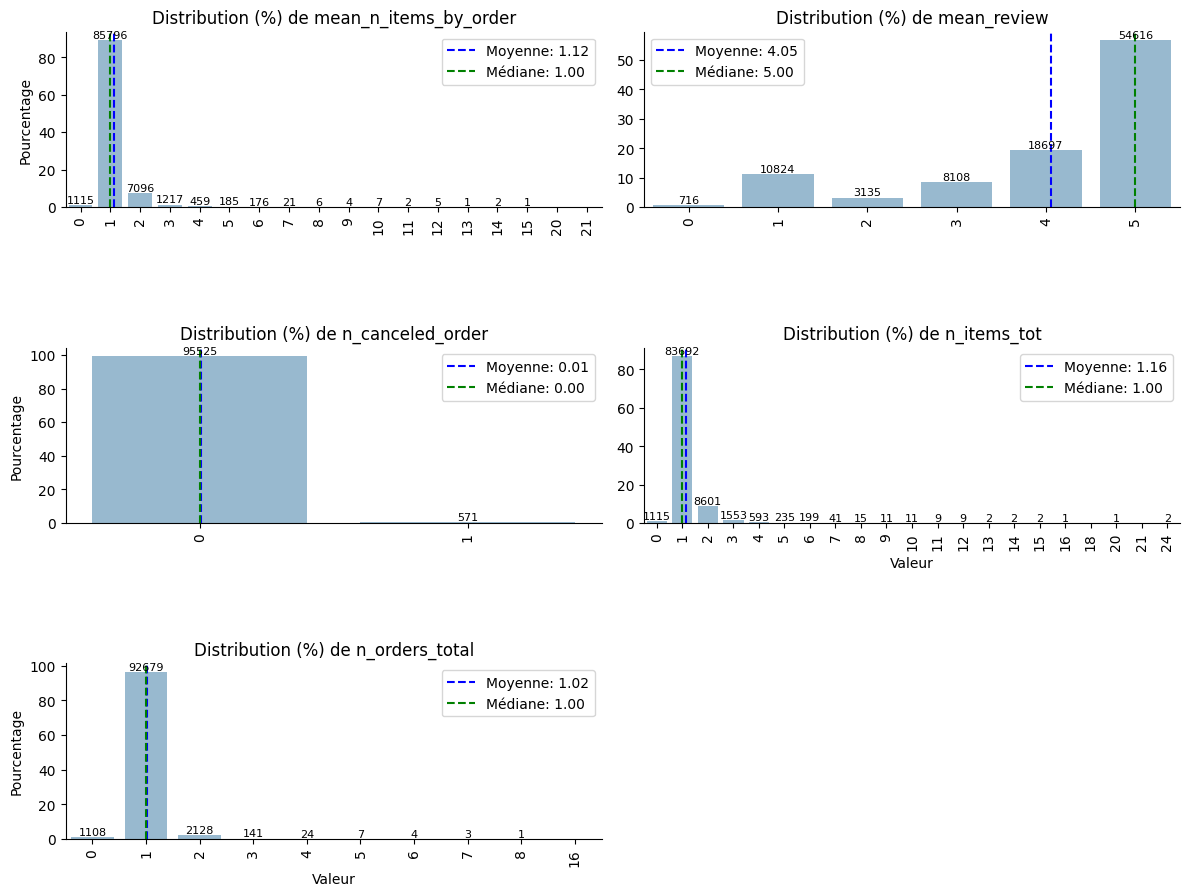

In [54]:
# Liste des variables à analyser
Analysed_features = ['mean_n_items_by_order',  'n_orders_total',
                     'n_items_tot',
                     'mean_review', 'n_canceled_order']

# Appel de la fonction
facet_percent_plot(orders_cust_agregrated, Analysed_features, "Distribution des variables numériques 1")

L'analyse univariée des variables discrètes met en évidence que la grande majorité des clients n'ont passé qu'une seule commande sur la plateforme d'Olist. Cette faible fréquence d'achat limite la variabilité de la variable fréquence qui constitue pourtant un critère central des approches classique de segmentation RFM (Récence, fréquence, Montant). En conséquent, cette variable risque d'avoir un pouvoir discriminant limité pour distinger différents profils de client. 

Par ailleurs, étant donnée que la plupart des clients n'ont effectué qu'un seul achat, la distribution du nombre total de produits acheté par client reflète étroitement celle du nombre de produits par commande. L'utilisation des deux variables serait donc redondante. Ainsi, seule une de ces deux variable ne sera conservée dans la suite de l'analyse.

De même, on remarque que très peu de client ont annulé des commande ce qui pourrait limiter la pertinence de cette variable dans une logique de regroupement. 

Enfin, l’analyse des évaluations clients montre que plus de la moitié d’entre eux ont attribué la note maximale. Les notes égales à zéro ne correspondent pas à une évaluation réelle : elles ont été imputées pour représenter les clients n’ayant laissé aucune note, la valeur 0 n’existant pas dans l’échelle de notation d’Olist. Le nombre de clients concernés reste marginale. Les autres évaluations se répartissent de manière relativement équilibrée sur le reste de l'échelle.

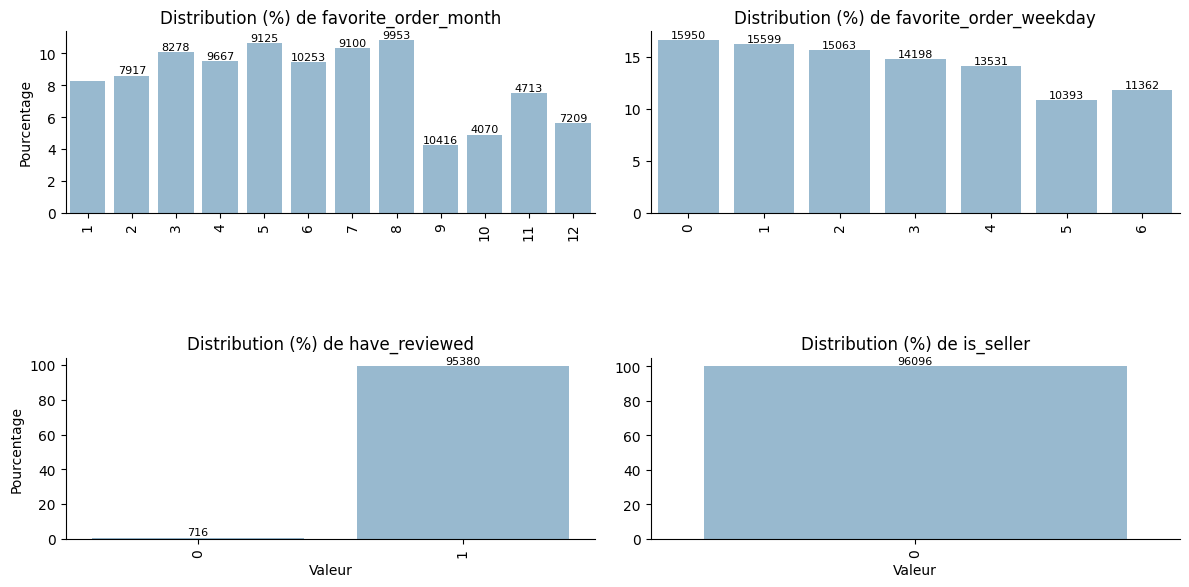

In [55]:
# Liste des variables à analyser
Analysed_features = ['is_seller', 'favorite_order_weekday', 'favorite_order_month', 'have_reviewed']

# Appel de la fonction
facet_percent_plot(orders_cust_agregrated, Analysed_features,  "Distribution des variables numériques catégorielles", mean_mediane=False)

Concernant les variable de type catégoriel, les graphiques révèlent qu'aucun idetifiant de client ne correspond à un identifiant de vendeur. Cela suggère qu'aucun client n'est aussi vendeur sur la plateforme, ou bien que les identifiants sont attribués selon des systèmes distincts pour chaque groupe d'utilisateurs.  

Par ailleurs, l'analyse des jours de commandes indique que les clients ont tendance à passer davantage de commandes en début de semaine comparativement à la fin de semaine (samedi et dimanche). De même, les données suggèrent une activité plus forte en début d'année. Il serait cependant pertinent de vérifier que cette hausse d'activité n'est pas entrainée par un biais lié a la période couverte par la base de données. 

In [56]:
# Extraction de la date de la dernière commande
Date_fin = orders['order_purchase_timestamp'].max()

# Etraction de la date de la première commande
Date_debut = orders['order_purchase_timestamp'].min()

# Affichage de la période couverte par la base
print(f"La base de données s'étend de {Date_debut} à {Date_fin}")

La base de données s'étend de 2016-09-04 21:15:19 à 2018-10-17 17:30:18


La base de données couvrant environs 2 ans et 1 mois environs, les mois de fin d'année et de début d'années sont équitablement représenté dans la base ce qui renforce la validité de l’analyse portant sur la distribution des commandes selon les mois de l’année.

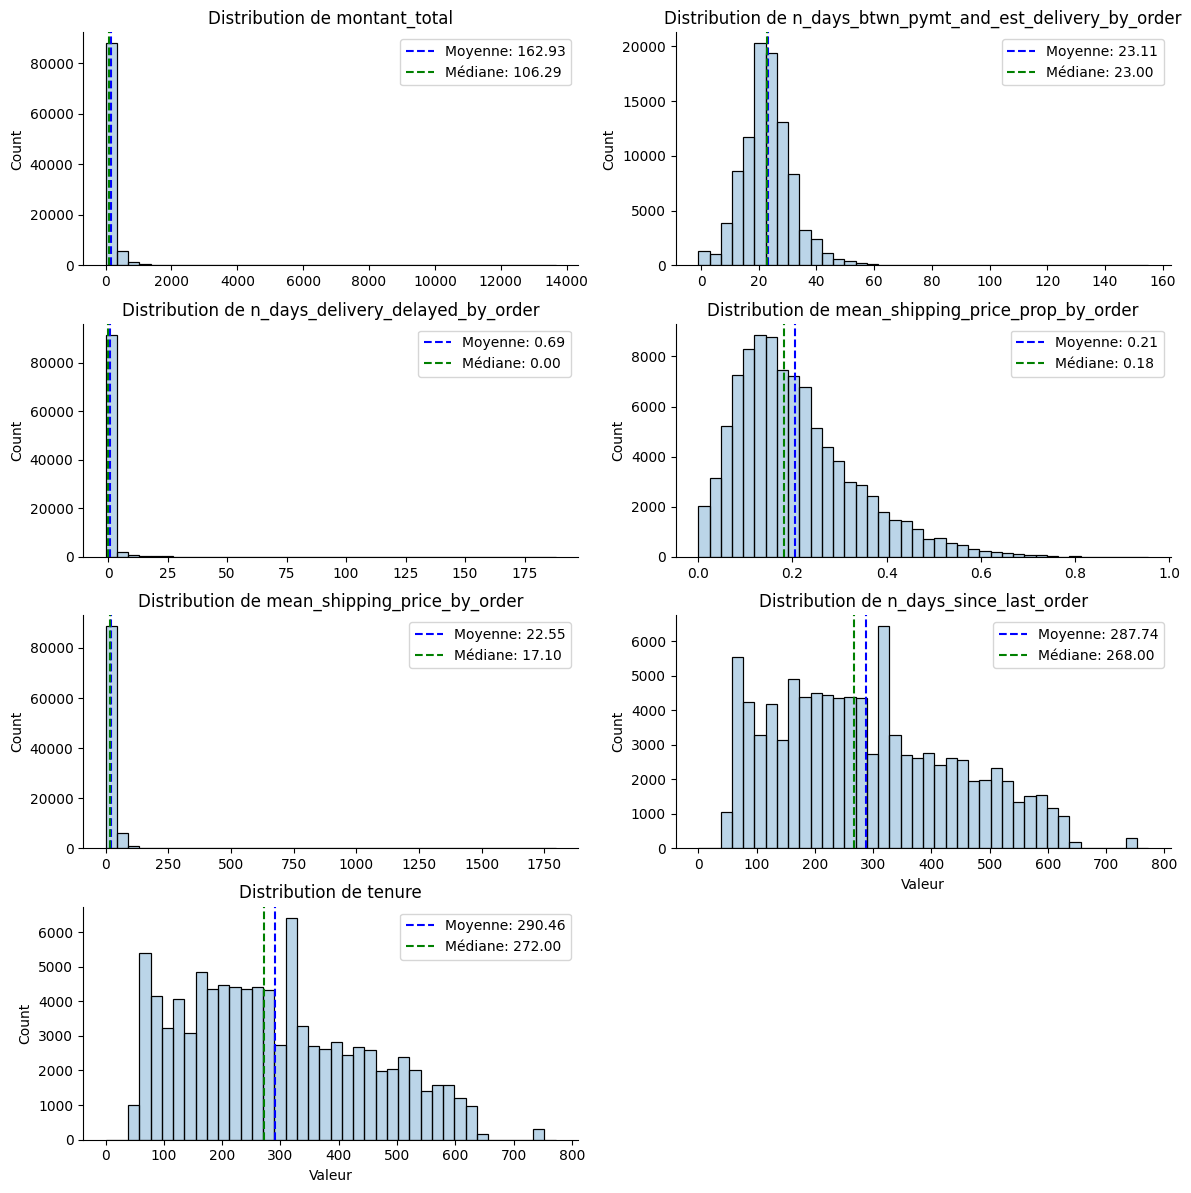

In [57]:
# Liste des variables à analyser
Analysed_features = ['montant_total', 'n_days_btwn_pymt_and_est_delivery_by_order',
                     'n_days_delivery_delayed_by_order', 'mean_shipping_price_prop_by_order',
                     'mean_shipping_price_by_order', 'n_days_since_last_order', 'tenure']

# Appel de la fonction
facet_hist_plot(orders_cust_agregrated, Analysed_features, "Distribution des variables numériques 2")

L'analyse de la distribution des variables continues met en évidence que 3 variables présentes une forte asymétrie. Il s'agit des variables montant total des commandes, nombre de jours de retard de livraison et frais de port moyen par commande. Ces variables sont caractérisées par une forte concentration de petites valeurs accompagnéeé de quelques valeurs extrêmes et rarement atteintes ce qui donne lieu a une distribution très étalée et déséquilibrée vers la droite. Dans le cadre d'une segmentaiton client, ce type de distribution peut poser plusieurs problèmes. En effet les algorithmes de segmentaiton sont souvent sensibles au distance et peuvent être influencés de façon excessive par les valeurs extrèmes. Il sera donc important de mettre en place un prétraitemetn des données adapté à ce type de distribution.

De nouveau, du fait que la majorité des client n'ont effectué qu'une commande, la distribution de l'ancienneté du client reflètement de manière étroite la distribution du nombre de jour écoulé depuis la dernier commande. Afin d'éviter toute redondance dans l'analyse, une seule de ces deux variables sera utilisée lors de la segmentaion client. Néanmoins, la distribution de ces variables montrent qu'il y a plus de nouveaux clients que d'anciens clients dans la base de donnée.

Enfin les variables représentant la proportion des frais de port par rapport au montant total de la commande ainsi que le temps entre la date d'achat et de livraison estimée présente une distribution plus proche d'une distribution normale bien qu'une légère asymétrie droite soit encore présente.

Afin de mieux visualiser les distributions des trois variables fortement asymétriques, une représentation graphique complémentaire sera réalisée. Pour cela, ces variables vont être discrétisées en intervalles croissants, permettant de mieux distinguer les zones de forte densité au début des distributions, tout en préservant l’information sur les valeurs extrêmes

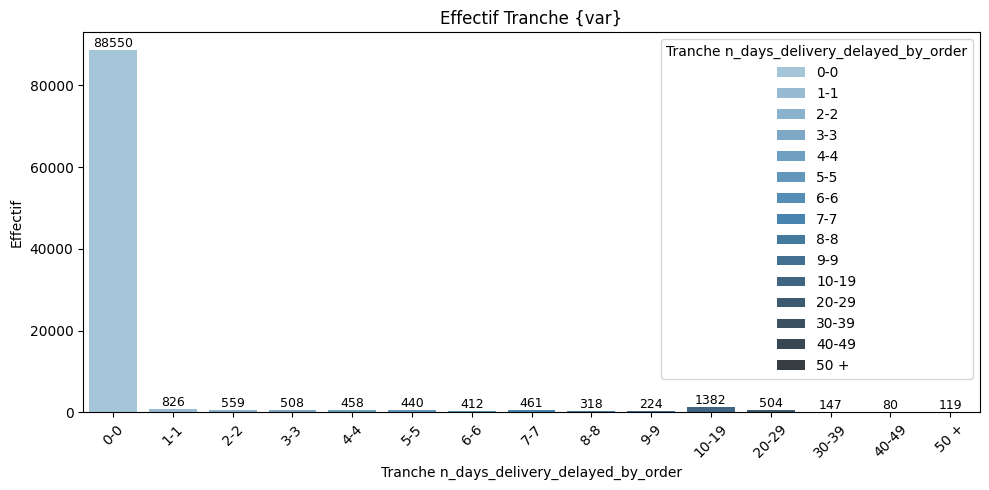

In [58]:
# Appel de la fonction
count_plot_tranche(orders_cust_agregrated, 'n_days_delivery_delayed_by_order', 1, 10, 10, 50, "Distribution de la variable jour de retard de livraison")

L'analyse plus fine du nombre de jours de retard à la livraison montre que la majorité des commandes ont été livrées dans les délais estimés.Les cas de retards sont donc plutôt rares mais lorsqu'ils surviennent, il peuvent être considérablement long, atteignant jusqu'à plus de 50 jours pour 119 clients. Bien que cette variable soit peu discriminante pour la majorité des clients, elle pourrait néanmoins s’avérer pertinente dans certains cas spécifiques, notamment à travers son interaction avec la variable représentant la satisfaction client exprimée par la note attribuée.

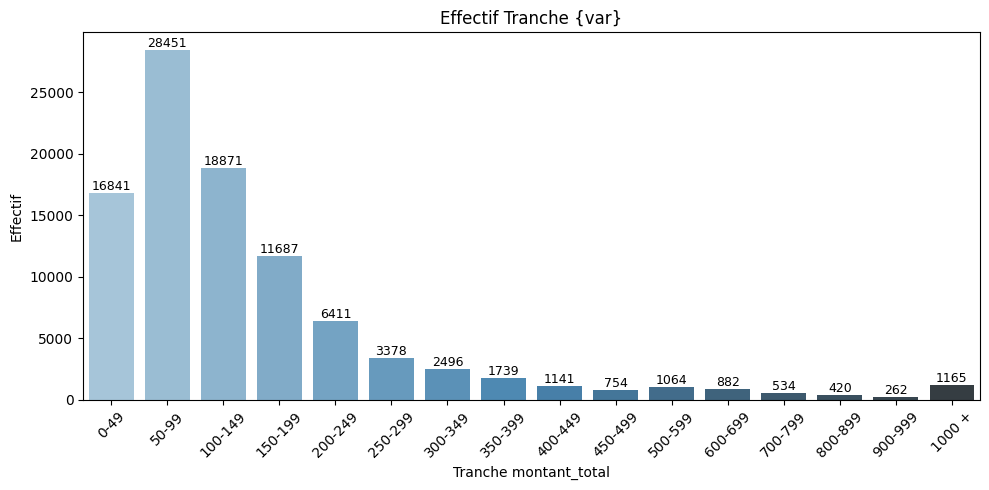

In [59]:
# Appel de la fonction
count_plot_tranche(orders_cust_agregrated, 'montant_total', 50, 100, 500, 1000, "Distribution de la variable montant total")

Lorsqu'on discrétise la variable montant en ciblant les petites valeurs de montant, on rettrouve la distribution asymétrique observée sur l'histogramme.

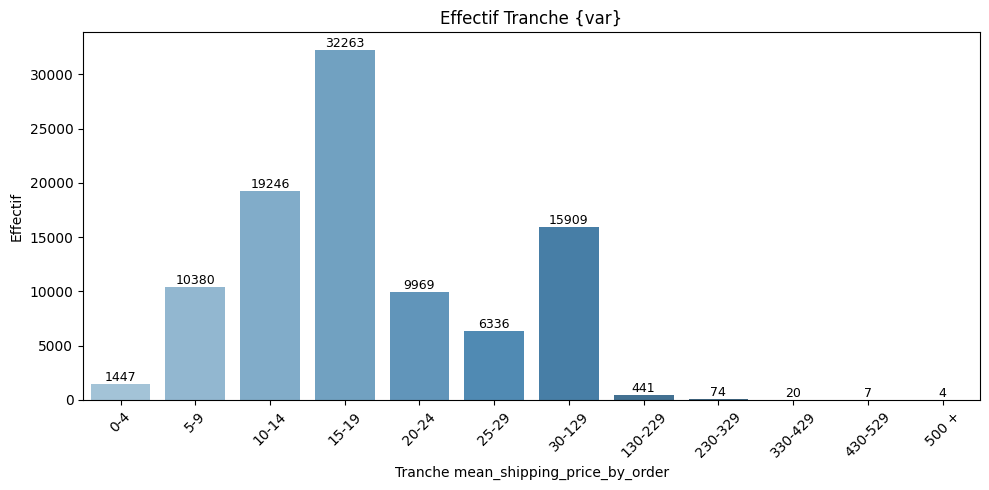

In [60]:
# Appel de la fonction
count_plot_tranche(orders_cust_agregrated, 'mean_shipping_price_by_order', 5, 100, 30, 500, "Distribuion de la variable prix moyen par commande")

L'analyse des frais de port montre que la majorité d'entre eux sont compris entre 15 et 19 reals. 
Les valeurs extrèmes de frais de ports paraissent très elevées. Durant la période couverte par le jeu de donnée, 1 euros représentait environs 3.9 Real. Il y a donc pour certaines commandes des frais de port qui s'élèvent à plus de 125 euros environs. Afin de déterminer si ces valeurs correspondent à des éventuelles erreurs ou à des valeurs atypique, on peut revenir vers les commandes associées à ces valeurs éelvées. 

## Verrification

In [61]:
# Affichage des commandes dont les frais de port se sont élevés à plus de 500 reals
orders_4[orders_4['shipping_price_by_order'] > 500].sort_values('shipping_price_by_order')

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,pymt_by_order,n_items_by_order,montant_all_items_by_order,shipping_price_by_order,shipping_price_prop_by_order,n_days_btwn_pymt_and_est_delivery_by_order,n_days_btwn_est_delivery_and_delivery_by_order,n_days_delivery_delayed_by_order
27964,27964,17784b9fbb37fb0bdc230d8ed6f6b355,023cf83ac35d703a6f3c1b31bcf844d5,delivered,2018-03-08 19:06:08,2018-03-09 19:08:21,2018-03-12 23:27:21,2018-03-23 15:08:41,2018-04-04,5a494c648fde2d1ec4eb614274ea7159,1342.98,6.0,840.00,502.98,0.374525,26,-12.0,0.0
16335,16335,71dab1155600756af6de79de92e712e3,8c20d9bfbc96c5d39025d77a3ba83d7f,delivered,2018-02-01 18:32:02,2018-02-01 19:37:42,2018-02-19 18:37:35,2018-03-12 18:58:21,2018-03-22,eae0a83d752b1dd32697e0e7b4221656,1988.55,11.0,1361.89,626.64,0.315124,48,-10.0,0.0
88772,88772,cfed507ac357129f750f05a0d7d71b15,088d20d5878711d537176871a6e850e4,delivered,2018-02-25 12:15:02,2018-02-26 22:10:27,2018-03-08 18:06:50,2018-04-06 01:26:34,2018-03-27,ef7361e14a64f77990f58e9c571e2f9a,2091.33,3.0,1380.00,711.33,0.340133,29,10.0,10.0
63700,63700,2455cbeb73fd04b170ca2504662f95ce,5e312b0d9bf5c91599eb42120e633b19,delivered,2017-06-20 12:39:46,2017-06-22 02:25:20,2017-06-26 15:33:02,2017-06-30 12:41:24,2017-07-12,066ee6b9c6fc284260ff9a1274a82ca7,1421.69,6.0,419.40,1002.29,0.704999,21,-12.0,0.0
20074,20074,cf4659487be50c0c317cff3564c4a840,ed583a2a1eaf0dedc33af816153e8b8c,delivered,2018-07-02 16:39:59,2018-07-05 16:04:19,2018-07-06 08:25:00,2018-07-16 11:12:52,2018-08-01,fff5eb4918b2bf4b2da476788d42051c,2844.96,6.0,1050.00,1794.96,0.630926,29,-16.0,0.0


Au total, 5 commandes sont associées à des frais de port s'élevant à plus de 500 reals. Pour aller plus loin, on peut rechercher quels sont les produits associés à ces commandes. 

In [62]:
# Initialisation de la dataframe
list_data_p = []

# Boucle sur les order_id ayant un shipping_price > 500
for o_id in orders_4[orders_4['shipping_price_by_order'] > 500]['order_id']:

    # Selection des lignes de order_items correspondant à cet order_id
    Data_p0 = order_items[order_items['order_id'] == o_id]

    # Merge avec les produits sur product_id
    Data_p = pd.merge(Data_p0, products, on='product_id', how='left')

    # Ajout l de e DataFrame au résultat global
    list_data_p.append(Data_p)

# Concaténation de toutes les DataFrames dans un seul
result_df = pd.concat(list_data_p, ignore_index=True)

# Affichage de la dataframe
result_df

,index_x,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,index_y,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,50094,71dab1155600756af6de79de92e712e3,1,90b58782fdd04cb829667fcc41fb65f5,7c67e1448b00f6e969d365cea6b010ab,2018-02-15 19:11:08,179.99,76.50,15316,moveis_escritorio,34.0,794.0,1.0,7417.0,102.0,46.0,11.0
1,50095,71dab1155600756af6de79de92e712e3,2,308e4e21ae228a10f6370a243ae59995,7c67e1448b00f6e969d365cea6b010ab,2018-02-15 19:11:08,76.99,40.69,26126,moveis_escritorio,41.0,1083.0,1.0,8250.0,53.0,74.0,18.0
2,50096,71dab1155600756af6de79de92e712e3,3,90b58782fdd04cb829667fcc41fb65f5,7c67e1448b00f6e969d365cea6b010ab,2018-02-15 19:11:08,179.99,76.50,15316,moveis_escritorio,34.0,794.0,1.0,7417.0,102.0,46.0,11.0
3,50097,71dab1155600756af6de79de92e712e3,4,308e4e21ae228a10f6370a243ae59995,7c67e1448b00f6e969d365cea6b010ab,2018-02-15 19:11:08,76.99,40.69,26126,moveis_escritorio,41.0,1083.0,1.0,8250.0,53.0,74.0,18.0
4,50098,71dab1155600756af6de79de92e712e3,5,90b58782fdd04cb829667fcc41fb65f5,7c67e1448b00f6e969d365cea6b010ab,2018-02-15 19:11:08,179.99,76.50,15316,moveis_escritorio,34.0,794.0,1.0,7417.0,102.0,46.0,11.0
5,50099,71dab1155600756af6de79de92e712e3,6,90b58782fdd04cb829667fcc41fb65f5,7c67e1448b00f6e969d365cea6b010ab,2018-02-15 19:11:08,179.99,76.50,15316,moveis_escritorio,34.0,794.0,1.0,7417.0,102.0,46.0,11.0
6,50100,71dab1155600756af6de79de92e712e3,7,308e4e21ae228a10f6370a243ae59995,7c67e1448b00f6e969d365cea6b010ab,2018-02-15 19:11:08,76.99,40.69,26126,moveis_escritorio,41.0,1083.0,1.0,8250.0,53.0,74.0,18.0
7,50101,71dab1155600756af6de79de92e712e3,8,308e4e21ae228a10f6370a243ae59995,7c67e1448b00f6e969d365cea6b010ab,2018-02-15 19:11:08,76.99,40.69,26126,moveis_escritorio,41.0,1083.0,1.0,8250.0,53.0,74.0,18.0
8,50102,71dab1155600756af6de79de92e712e3,9,308e4e21ae228a10f6370a243ae59995,7c67e1448b00f6e969d365cea6b010ab,2018-02-15 19:11:08,76.99,40.69,26126,moveis_escritorio,41.0,1083.0,1.0,8250.0,53.0,74.0,18.0
9,50103,71dab1155600756af6de79de92e712e3,10,308e4e21ae228a10f6370a243ae59995,7c67e1448b00f6e969d365cea6b010ab,2018-02-15 19:11:08,76.99,40.69,26126,moveis_escritorio,41.0,1083.0,1.0,8250.0,53.0,74.0,18.0


On peut s'apercevoir que les produits associés aux commandes avec des frais de port s'élevant à plus de 500 reals correspondent aux catégories : moveis sala (meubles de salon), moveis decoracao (meubles et décoration), moveis escritorio (meuble de bureau) et sinalizacao e seguranca (signalisation et sécurité). Les produits avec des frais de port élevées correspondent donc probablement à des produits de grande taille dont les frais de port sont en général plus élevé. Les valeurs de frais de ports identifiées dans le graph précédent comme élevés ne paraissent pas anormales au vu de la nature des produits associés à ces commandes. 

## Correlation 

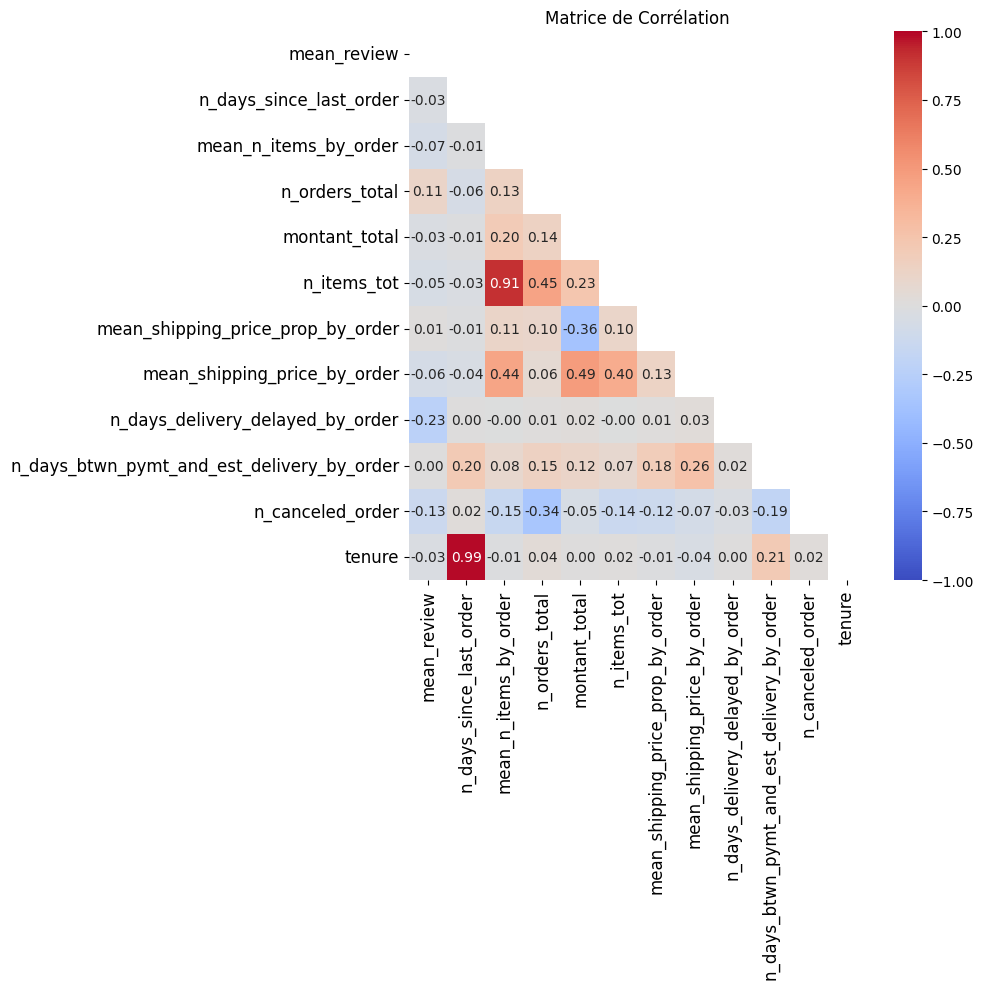

In [63]:
# Définition des variable à analyser
Analysed_features = [col for col in orders_cust_agregrated.columns
                     if orders_cust_agregrated[col].dtype in ['float64', 'int64']]

# Normalisation des données
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(orders_cust_agregrated[Analysed_features])

# Conversion des données normalisée en dataframe
Data_df = pd.DataFrame(X_scaled, columns=Analysed_features)

# Construction d'une matrice de corrélation des variables
corr_matrix = Data_df.corr()

# Définition d'un mask pour n'afficher que la diagonale inférieure de la matrice de corrélation
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Construction d'une heatmap représentant les corrélations des différentes variables
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Matrice de Corrélation')
plt.yticks(fontsize=12)
plt.xticks(rotation=90, fontsize=12)
plt.tight_layout()

# Sauvegarde de la heatmap
plt.savefig(f'../Output/Corrélations/Corrélations entre variable.png', format='png')

# Affichage de la heatmap
plt.show()

La représentation graphique de la matrice des corrélation des variables numériques met en évidence les deux couples de variables pour lesquels des distributions quasi identiques avaient déjà été observées lors de l’analyse univariée. En dehors de ces redondances déjà identifiées, les autres variables apparaissent faiblement corrélées entre elles, ce qui suggère une complémentarité d’information utile pour la segmentation

# Sauvegarde de la table profil client

In [64]:
# Copie de la dataframe
Customer_final = orders_cust_agregrated.copy()

# Sauvegarde de la dataframe
Customer_final.to_csv("../Output/Table/Customer_final.csv", index=True)

# Conclusions

La première phase de ce projet à consisté à explorer la base de données issue de la plateforme d'Olist dans le but de construire une table reflètant le profil de chaque client. Cette étape exploratoire a permis d'identifier des variables pertinentes pour caractériser les clients et alimenter la phase de segmentation.

La construction des caractéristiques client s'est effectué en deux étapes. Tout d'abord toutes les informations propres à chaque commandes et nécessaire à la création des caractéristiques souhaitées ont été rassemblées dans la table associée aux commandes. La seconde étapes à consisté à créer les différentes variables en utilisant des fonctions de regroupement sur l'identifiant unique de chaque client pour construire des variable représentatives de leur comportement. La distributions des indcateurs a ensuite été analysé. Cela a permis de constater que la très grande majorité des clients n'a effectué qu'une seule commande sur la période couverte par la base de donnée.  Par conséquent, la variable fréquence d’achat, bien qu’habituellement centrale dans les segmentations RFM, présente ici une très faible variabilité, ce qui pourait limiter sa capacité à différencier les clients. Elle sera néanmoins conservée, car elle constitue un standard des approches de segmentation et pourrait malgré tout s’avérer utile en combinaison avec d’autres variables. D’autres variables, initialement jugées pertinentes d’un point de vue métier, seront probablement écartées en raison de leur faible pouvoir discriminant, de leur redondance ou de distributions trop déséquilibrées.

L’étape suivante du projet consistera à mettre en œuvre la segmentation client, en testant différentes approches algorithmiques. L’objectif sera d’identifier des groupes de clients homogènes et actionnables, afin de guider les équipes marketing d’Olist dans la mise en place de stratégies de communication ciblées et personnalisées.